## Name: Andrew Caide
### CSCI S-89C Deep Reinforcement Learning  
### Part II of Final

In [1]:
import time
import random
import pickle

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from keras import layers
from keras import models
from keras.layers import Dropout
from keras.datasets import mnist

## Problem 1 (5 points)

Consider the optimal selection of a treatment. Suppose that there are 4 types of treatments available. The outcome of each treatment is either 1 (recovery) or 0.   

Let's denote the outcome by $R_t$, then $R_t|(A_t=a)$ follows $\text{Bernoulli}(p_a)$ with $a\in\{1,2,3,4\}$ and all $p_a\in [0,1]$, where $A_t$ denotes the action on time step $t=1,2,3,\ldots$. 

Assume that $p_1=0.05$, $p_2=0.15$,  $p_3=0.55$, $p_4=0.85$, which are not known to the doctor. This is the 4-armed Bandit Problem with Bernoulli distributions. The rewards $R_t$ are 0's and 1's. Please notice that $P\{R_t=1|A_t=a\}=p_a$. Also, the expectation $E\left[R_t|A_t=a \right]=p_a$.

Develop the Upper-Confidence-Bound Action Selection algorithm for the problem of selecting the best treatment and report the following graphs:   

(a) Run the algorithm for $t=1,2,3,\ldots,400$ and plot $R_t$'s v.s. $t$ for one simulation. Use $c=0.15$.   
(b) Run 100 trajectories in (a); and for each time step $t$ plot the average of $R_t$'s from all 100 trajectories at this particular time (please do not average all returns over time - we want to see how the learning progresses over time). Use $c=0.15$.   
(c) Using trajectories you obtained in (b), for each time step $t$, plot the proportion  (out of 100) of times the best action (action $a=4$) was selected by the doctor. Again, use $c=0.15$.

----

0. Develop the Upper-Confidence-Bound Action Selection algorithm for the problem of selecting the best treatment.

In [2]:
class Environment:
    def __init__(self):
        self.time = 1
        self.valid_actions = {1:0.05, 2:0.15, 3:0.55, 4:0.85} 
    
    def get_reward(self, action):
        self.time += 1
        p1 = 1-self.valid_actions[action]
        p2 = self.valid_actions[action]
        return np.random.choice([0, 1],p=[p1, p2])
    
    
class UCB_Agent:
    def __init__(self, c = 0.15):
        self.c = c
        self.Q = np.zeros(4)
        self.t = np.zeros(4)
        self.rewards = []
        self.actions_taken =[]
        self.best_action_taken = []
        self.four_counter = 0

    def step(self, env):
        
        # Test all actions first
        if any(self.t) == 0:
            for action in range(1,5):
                reward = env.get_reward(action)
                
                self.Q[action-1] = reward
                self.t[action-1] += 1
                
                self.actions_taken.append(action)
                self.rewards.append(reward)
                if action == 4:
                    self.four_counter +=1
                self.best_action_taken.append(self.four_counter)
                
        else:
            # UCB Action Selection:
            best_action = np.argmax(self.Q + self.c*np.sqrt(np.log(self.t)/self.t))+1
            reward = env.get_reward(best_action)
            
            self.actions_taken.append(best_action)
            self.rewards.append(reward)
            
            self.Q[best_action-1] = reward
            self.t[best_action-1] += 1
            
            if best_action == 4:
                self.four_counter +=1
            self.best_action_taken.append(self.four_counter)

---
(a) Run the algorithm for $t=1,2,3,\ldots,400$ and plot $R_t$'s v.s. $t$ for one simulation. Use $c=0.15$.   
  

In [3]:
env = Environment()
agent = UCB_Agent()
for t in range(0,397):
    agent.step(env)
action_rewards = pd.DataFrame({"Actions":agent.actions_taken, "Rewards":agent.rewards})
action_rewards['time'] = action_rewards.index + 1
action_rewards.head(2)

,Actions,Rewards,time
0,1,0,1
1,2,0,2


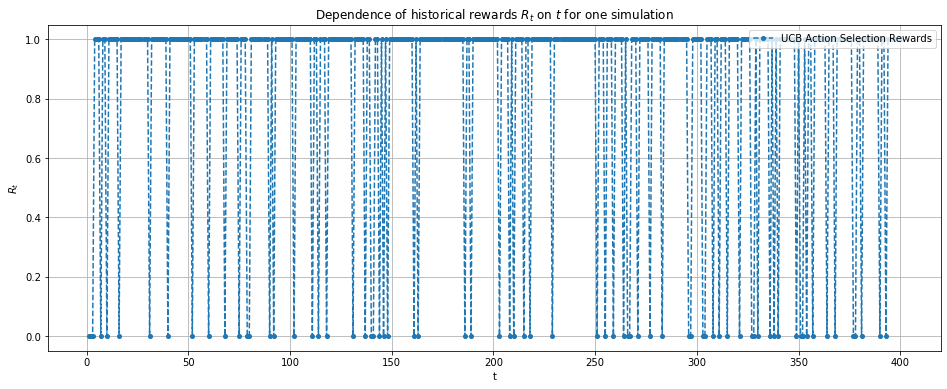

In [4]:
plt.figure(figsize=(16,6))
plt.plot(action_rewards['time'], action_rewards['Rewards'], linestyle='--', 
         marker='o', markersize=4, label='UCB Action Selection Rewards')
plt.xlabel("t")
plt.ylabel("$R_t$")
plt.title('Dependence of historical rewards $R_t$ on $t$ for one simulation')
plt.grid(True)
plt.legend(loc = 'upper right')
plt.show()

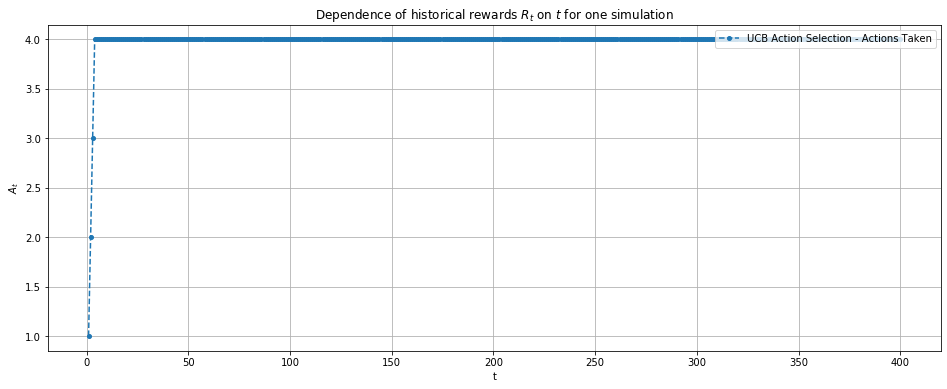

In [5]:
plt.figure(figsize=(16,6))
plt.plot(action_rewards['time'], action_rewards['Actions'], linestyle='--', 
         marker='o', markersize=4, label='UCB Action Selection - Actions Taken')
plt.xlabel("t")
plt.ylabel("$A_t$")
plt.title('Dependence of historical rewards $R_t$ on $t$ for one simulation')
plt.grid(True)
plt.legend(loc = 'upper right')
plt.show()

(b) Run 100 trajectories in (a); and for each time step $t$ plot the average of $R_t$'s from all 100 trajectories at this particular time (please do not average all returns over time - we want to see how the learning progresses over time). Use $c=0.15$. 

In [12]:
q1_partb = pd.DataFrame()

for i in range(0,101):
    env = Environment()
    agent = UCB_Agent()
    for t in range(0,397):
        agent.step(env)
        
    action_rewards = pd.DataFrame({"Actions":agent.actions_taken, 
                                   "Rewards":agent.rewards,
                                   "Fours":agent.best_action_taken})
    action_rewards['time'] = action_rewards.index + 1
    q1_partb = q1_partb.append(action_rewards)
    

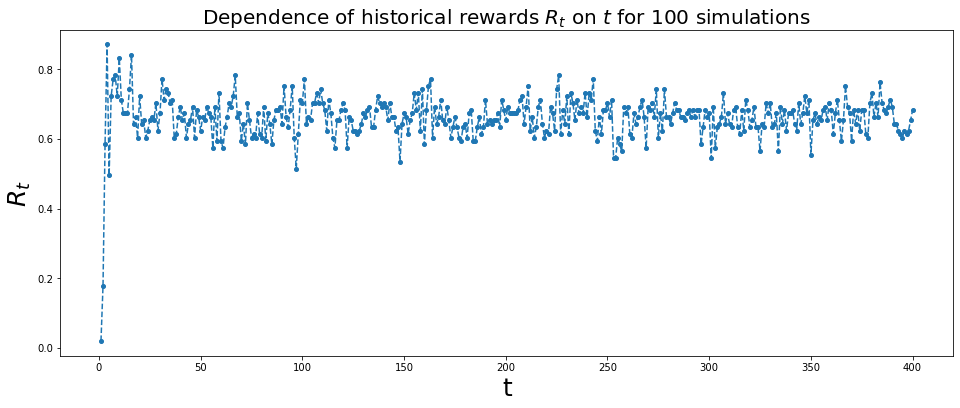

In [14]:
average_reward = q1_partb.groupby('time')['Rewards'].mean()
plt.figure(figsize=(16,6))
plt.plot(average_reward.index, average_reward.T, linestyle='--', 
         marker='o', markersize=4,)
plt.xlabel("t",fontsize = 25.0)
plt.ylabel("$R_t$",fontsize = 25.0)
plt.title('Dependence of historical rewards $R_t$ on $t$ for 100 simulations',fontsize = 20.0)
plt.show()

(c) Using trajectories you obtained in (b), for each time step $t$, plot the proportion  (out of 100) of times the best action (action $a=4$) was selected by the doctor. Again, use $c=0.15$.

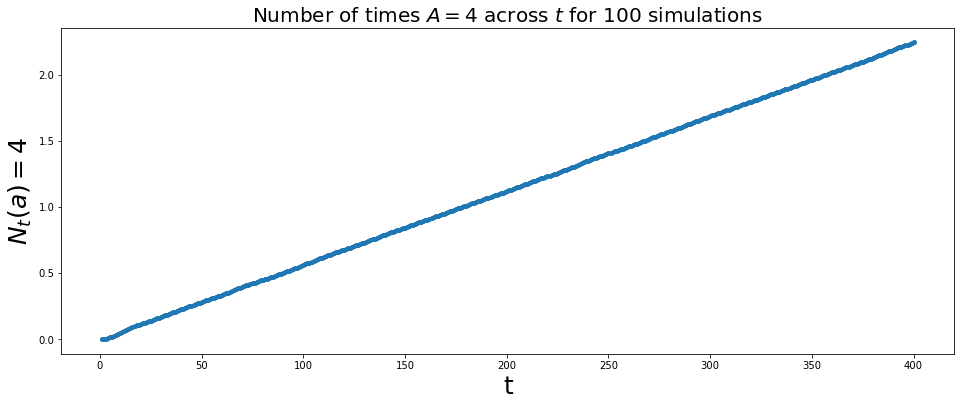

In [15]:
average_reward = q1_partb.groupby('time')['Fours'].mean()/100
plt.figure(figsize=(16,6))
plt.plot(average_reward.index, average_reward.T, linestyle='--', 
         marker='o', markersize=4,)
plt.xlabel("t",fontsize = 25.0)
plt.ylabel("$N_t(a) = 4$",fontsize = 25.0)
plt.title('Number of times $A=4$ across $t$ for 100 simulations',fontsize = 20.0)
plt.show()

## Problem 2 (5 points)

Consider Environment that has five states: 1, 2, 3, 4, and 5. Possible transitions are: (1) 1->1, 1->2; (2) 2->1, 2->2, 2->3; (3) 3->2, 3->3, 3->4; (4) 4->3, 4->4, 4->5; (5) 5->4, 5->5.

Actions of the Agent are decoded by -1, 0, and +1, which correspond to its intention to move left, stay, and move right, respectively. The Environment, however, does not always respond to these intentions exactly, and there is 10% chance that action 0 will result in moving to the right (if moving to the right is admissible), and -1 action will result in staying - in other words, there is a "west wind." More specifically, the non-zero transition probabilities $p(s^\prime,r|s,a)$ are  

$p(s^\prime=1,r=0|s=1,a=0)=0.9, p(s^\prime=2,r=0|s=1,a=0)=0.1$,  
$p(s^\prime=2,r=0|s=1,a=+1)=1$,<br>

$p(s^\prime=1,r=0|s=2,a=-1)=0.9, p(s^\prime=2,r=0|s=2,a=-1)=0.1$,<br>
$p(s^\prime=2,r=0|s=2,a=0)=0.9,p(s^\prime=3,r=-10|s=2,a=0)=0.1$,<br>
$p(s^\prime=3,r=-10|s=2,a=+1)=1$,<br>

$p(s^\prime=2,r=0|s=3,a=-1)=0.9,p(s^\prime=3,r=-10|s=3,a=-1)=0.1$,<br>
$p(s^\prime=3,r=-10|s=3,a=0)=0.9,p(s^\prime=4,r=0|s=3,a=0)=0.1$,<br>
$p(s^\prime=4,r=0|s=3,a=+1)=1$,<br>

etc.

Further, we assume that whenever the process enters state 3, the Environment generates reward = -10. In all other cases the reward is 0. For example, transition 2->3 will result in reward -10, transition 3->3 will result in reward -10, transition 3->2 will result in reward 0, transition 2->2 will result in reward 0, etc.



Further, assume that the agent does not know about the wind or what rewards to expect. It chooses to stay in all states, i.e. the policy is
$\pi(-1|1)=0, \pi(0|1)=1, \pi(+1|1)=0$,<br>
$\pi(-1|2)=0, \pi(0|2)=1, \pi(+1|2)=0$,<br>
$\pi(-1|3)=0, \pi(0|3)=1, \pi(+1|3)=0$,<br>
$\pi(-1|4)=0, \pi(0|4)=1, \pi(+1|4)=0$,<br>
etc.

Please estimate the state-value function using 2-step Temporal Difference (TD) prediction. Let’s use $\gamma=0.9$ and run the episodes for $T=100$.


In [20]:
class P2_Environment:
    def __init__(self, S0 = 1):
        self.time = 0
        self.state = S0

    def admissible_actions(self):
        A = list((-1,0,1))
        if self.state == 1: A.remove(-1)
        if self.state == 5: A.remove(1)
        return A

    def get_reward(self, action):
        self.time += 1
        move = action
        if self.state < 5 and move > -1:
            move = np.random.choice([move+1, move],p=[0.1,0.9])
        self.state += move
        if self.state == 3:
            reward = -10
        else:
            reward = 0
        return reward
    
class P2_Agent:
    def __init__(self):
        self.current_reward = 0.0

    def step(self, env):
        action_selected = 0
        reward = env.get_reward(action_selected)            
        self.current_reward = reward

In [21]:
# Run 1 EP:

class V_2StepTD:
    def __init__(self, S0=1, gamma = 0.9):
        self.S0 = S0
        self.gamma = gamma
        self.V = np.zeros(5)

        # Set env+agent 
        self.env = P2_Environment(S0)
        self.agent = P2_Agent()
    
    def update_V(self):      
        G = 0
        
        agent.step(env)
        r1 = self.agent.current_reward
        S1 = self.env.state
        self.agent.step(self.env)
        r2 = self.agent.current_reward
        v = self.V[self.env.state-1]
        
        self.V[self.S0-1] = r1 + r2*self.gamma + v*self.gamma**2
        
        # Take a step back to S1 (aka S0+t)
        self.env = P2_Environment(S1)
        self.S0 = S1

In [22]:
def scan_2StepTD(T = 100):
    # We're going to scan states 1-5 100 times each, and take average
    
    results = pd.DataFrame()
    for state0 in range(1,6):
        state_values = pd.DataFrame()
        system = V_2StepTD(state0)
        
        for t in range(0,T):
            system.update_V()
            state_values = state_values.append(pd.DataFrame(system.V).T, ignore_index = True)
        state_values = state_values.mean().T
        results = results.append(state_values, ignore_index = True)
    
    
    return results.sum(axis=1)
    

In [23]:
scan_2StepTD()

0     0.000000
1    -7.493495
2   -61.953411
3     0.000000
4     0.000000
dtype: float64

## Problem 3 (5 points)

In this problem, we consider the optimization of hospital patient flow using the Markov Decision Process. We assume that the hospital can hold 300 patients at most.

Further, we introduce three states as follows:   

"Low" if number of patients is in $[0,100)$   
"Medium" if number of patients is in $[101,200)$   
"High" if number of patients is in $[201,300]$    

Please notice that this aggregation is an improtant step as it allows one to accuratly estimate the transition probabilities from state to state using the database that tracks journeys of patients through the hospital from arrival to discharge.



One time step corresponds to one day and the administration of the hospital can select the following actions:

If the hospital has "Low" number of patients, then $a \in \{0\}$, where $0$ indicates that no patient will be released early.   
If the hospital has "Medium" number of patients, then $a \in \{0,1\}$, i.e. besides action $a=0$, only one additional action is admissible, namely $1$. This action corresponds to releasing $10$ patients early.   
If the hospital has "High" number of patients, then $a \in \{0,1,2\}$, i.e. besides action $a=0$, two additional actions, namely $1$ and $2$, are admissible. Action $a=1$ again corresponds to releasing $10$ patients early, while action $2$ indicates releasing $20$ patients early.  
   
<br>
        
Further, assume that we found the transition probabilities $p(S_{t+1}=s^\prime|S_t=s,A_t=a)$ to be (for a data-driven estimates refer, for instance, to "Markov Decision Process Model for Optimisation of Patient Flow" by Clissold, J. Filar, S. Qin, and D.Ward, 21st International Congress on Modelling and Simulation, Gold Coast, Australia, 29 Nov to 4 Dec 2015):   

$p(S_{t+1}=s^\prime|S_t=s,A_t=0)=\begin{bmatrix} 
0.8 & 0.2 & 0 \\
0.25 & 0.7 & 0.05\\
0.01 & 0.25 & 0.74\\
\end{bmatrix}$    

Here, we use the Markov Chain convention with $s$ being the row index (in the order from "Low" to "Hight"), and $s^\prime$ being the column index.    
For example, $p(S_{t+1}=\text{"High"}|S_t=\text{"Medium"},A_t=0)=0.05$ and $p(S_{t+1}=\text{"Medium"}|S_t=\text{"Low"},A_t=0)=0.2$.

If, however, the hospital decides to release $10$ patients early, i.e. $A_t=1$, the probability of moving to a "lower" hospital occupancy level are now larger, while the probability of moving to a "higher" state are smaller:  

$p(S_{t+1}=s^\prime|S_t=s,A_t=1)=\begin{bmatrix} 
- & - & - \\
0.25+0.1 & 0.7-0.09 & 0.05-0.01\\
0.01+0.01 & 0.25+0.09 & 0.74-0.1\\
\end{bmatrix}$ 

where same $s, s^\prime$ index convention is used. Plase notice that in state $s=\text{"Low"}$ action $A_t=1$ is unavailable resuting in missing probabilities (denoted by "-") in the matrix above. On the other hand, $p(S_{t+1}=\text{"High"}|S_t=\text{"Medium"},A_t=1)=0.05-0.1$, for example.

Finally, if the decision maker selects to reaease $20$ patients early, i.e. $A_t=20$, then   

$p(S_{t+1}=s^\prime|S_t=s,A_t=2)=\begin{bmatrix} 
- & - & - \\
- & - & -\\
0.01+0.02 & 0.25+0.18 & 0.74-0.2\\
\end{bmatrix}.$   
   
<br><br>
        
The reward $R_{t+1}$ obtained as a result of action $A_t$ is defined as follows:   
$R_{t+1}=\frac{1}{10}\left[\mathbb{1}_{\{S_{t+1}=\text{"Low"}\}}\cdot 49.5+\mathbb{1}_{\{S_{t+1}=\text{"Medium"}\}}\cdot 150.5+\mathbb{1}_{\{S_{t+1}=\text{"High"}\}}\cdot 255.5 + A_t\cdot (-10)\right]+\frac{9}{10}\left[\mathbb{1}_{\{S_{t+1}=\text{"High"}\}}\cdot (-30)\right]$.

Here, the first term $\frac{1}{10}\left[\ldots\right]$ is related to the direct profit of the hospital, while the second term $\frac{9}{10}\left[\ldots\right]$ is associated with the inconvenience of patients, risk of refusal for admission of new patients, and the reputation of the hospital.

<br>
Using this information, please find the optimal policy for the decision making via Double Q-learning. Use $\gamma=0.9$. Please treat this problem as a continuing task.

In [13]:
class P3_Environment:
    def __init__(self, S0):
        self.time = 1
        self.state = S0
        self.new_state = 0
        self.trans_probabilities = 0
        self.action = 0
        self.p = 0
        
    def set_state(self, new_state):
        self.state = new_state
        
    
    def set_transition_probabilities(self):
        if self.action == 0:
            self.trans_probabilities = [np.array([.8, .2, 0]),
                                              np.array([.25, 0.7, 0.05]),
                                              np.array([0.01, 0.25, 0.74])][self.state]
        elif self.action == 1:
            self.trans_probabilities = [np.array([0, 0, 0]),
                                              np.array([.25+.1, 0.7-0.09, 0.05-0.01]),
                                              np.array([0.01+0.01, 0.25+0.09, 0.74-0.1])][self.state]
        else:
            self.trans_probabilities = [np.array([0, 0, 0]),
                                              np.array([0, 0, 0]),
                                              np.array([0.01+0.02, 0.25+0.18, 0.74-0.2])][self.state]
            
    def get_reward(self):
        return np.array([1/10*(49.5 + (-10)*self.action),
                        1/10*(150.5 + (-10)*self.action),
                        1/10*(255.5 + (-10)*self.action) + 9/10*(-30)])
        
        
    def evaluate(self, action):
        # With the new action, and the new state
        #   1. get transaction probability based on [action -> state -> newstate]
        #   2. save p
        #   3. get reward
        self.action = action
        self.set_transition_probabilities()
        #print("State: {}, Action: {}".format(self.state, self.action))
        #print("Transition probabilities: {}.".format(self.trans_probabilities))
        
        if sum(self.trans_probabilities) != 0:
            new_state = np.random.choice([0,1,2], p=self.trans_probabilities)
            #print("New state: {}\n---".format(new_state))
            self.state = new_state
            self.p = self.trans_probabilities[new_state]
            return self.get_reward()[new_state]
        
        else:
            return self.get_reward()[self.state]

In [14]:
class P3_Agent:
    def __init__(self):
        self.current_reward = 0.0
        self.scan = 1
        self.scan_done = False

    def step(self, env, take_action = False, policy = 1):
        if take_action:
            action_selected = take_action
        else:
            action_selected = 0 # Stay put
        
        self.current_reward = env.evaluate(action_selected)            

In [15]:
def get_policy_from_q(q, eps):
    # Get the optimal policy given a specific state-value Q
    # Identify max value, set it as the e-greedy value!
    
    if np.count_nonzero(q == 0) == 1:
        policy = pd.DataFrame(eps/2, index=range(1,2), columns={0,1,2})
        policy.loc[:,q.idxmax(1)] = 1-eps + eps/2
        policy.loc[:,q.idxmin(1)] = 0
        
    elif np.count_nonzero(q == 0) == 2:
        policy = pd.DataFrame(0, index=range(1,2), columns={0,1,2})
        policy.loc[:,q.idxmax(1)] = 1
    else:
        policy = pd.DataFrame(eps/3, index=range(1,2), columns={0,1,2})
        policy.loc[:,q.idxmax(1)] = 1-eps + eps/3
    
    return(policy.values.tolist()[0])

In [16]:
def double_q(alpha = 0.1, gamma = 0.9, episodes = 200, eps = .3, T = 100):
    # initiate Q1, Q2 for all S and A, such that terminal = 0
    Q1 = pd.DataFrame(1, index=range(0,3), columns={0,1,2})
    Q1.loc[0,1] = 0
    Q1.loc[0,2] = 0
    Q1.loc[1,2] = 0

    Q2 = pd.DataFrame(1, index=range(0,3), columns={0,1,2})
    Q2.loc[0,1] = 0
    Q2.loc[0,2] = 0
    Q2.loc[1,2] = 0
    
    for episode in range(episodes):
        S0 = random.randint(0,2)
            
        env = P3_Environment(S0)
        agent = P3_Agent()
        S = env.state
        t = 0
        while t<T:
            t+=1
            action_vals = Q1+Q2
            #print("Action Value Table: \n{}".format(action_vals))
            Q = action_vals.loc[S]
            
            # Make greedy policy
            policy = get_policy_from_q(Q, eps)
            #print("Policy: {}\n---".format(policy))
            
            A = np.random.choice([0, 1, 2], 1, p=policy)[0] 
            #print("Double-Q policy: {}".format(policy))
            
            # Take action A, observe R, S'
            agent.step(env, take_action = A)
            reward = agent.current_reward    # R
            S1 = env.state                   # S'
            
            # With a 0.5 probability:
            if random.choice([True,False]):
                # Argmax Q1(S',*)
                try:
                    best_q1_action = Q1.loc[S1].idxmax(1)

                    Q1.loc[S,A] = Q1.loc[S,A] +\
                        alpha*(reward + gamma*Q2.loc[S1,best_q1_action] - Q1.loc[S,A])
                    #print("Updated Q1: \n{}".format(Q1))
                except:
                    print("State: {}, Action: {}, Q1: ".format(S1, A))
                    print(Q1)

            else:
                # Argmax Q2(S',*)
                try:
                    best_q2_action = Q2.loc[S1].idxmax(1)

                    Q2.loc[S,A] = Q2.loc[S,A] +\
                        alpha*(reward + gamma*Q1.loc[S1,best_q2_action] - Q2.loc[S,A])
                    #print("Updated Q2: \n{}".format(Q2))
                except:
                    print("State: {}, Action: {}, Q2: ".format(S1, A))
                    print(Q2)
                    
            S = S1 # S <- S'

    Q_final = Q1+ Q2
    return Q_final.divide(Q_final.max(axis=1), axis=0)

In [17]:
dqres = double_q()
print("Action-Value by Actions (columns) x States (rows):\n{}".format(dqres))
print("\n----\n")
print("Optimal actions:\n{}".format(dqres.idxmax(1)))

Action-Value by Actions (columns) x States (rows):
          0         1    2
0  1.000000  0.000000  0.0
1  1.000000  0.975555  0.0
2  0.890097  0.886018  1.0

----

Optimal actions:
0    0
1    0
2    2
dtype: int64


## Problem 4 (10 points)

In this problem we will develop an algorithm for approximating state values using Deep Neural Network (NN). We consider images of size 28x28, which can be treated as vectors of 784 features: ${\bf x}=(x_1,x_2,\ldots,x_{784})^T$.

Please load the observations of features ${\bf x}(S_t)$, $t=0,1,\ldots$ ('images' variable), actions $A_t$, $t=0,1,\ldots$ ('actions' variable), and rewards $R_t$, $t=1,2,\ldots$ from the 'markov_decision_process.pkl' file. Please notice that in each state $s\in \mathcal{S}$, the set of admissible actions is $\mathcal{A}(s)=\{0,1,2\}$. Here, "0" states for no treatment and "1" and "2" are two treatments of different types. We assume that this is a Markov Decision Process, that is, the joint distribution of the next state $S_{t+1}$ and reward $R_{t+1}$ depens on the pair of current state and action $(S_t, A_t)$ only.

These rewards were obtained under uniform policy $\pi$, that is, actions were selected at random from the action space $\mathcal{A}(s)$. Please develop a 1-step TD prediction algorithm with approximation via a Deep NN to evaluate state values $v_\pi(s)$ under this pilicy $\pi$. Please use the vector of fetures ${\bf x}(S_t)$ as an input to the NN. The output of the NN should be the state-values $\hat{v}(S_t,{\bf w})$. Please feel free to use either feedforward fully connected NN or Convolutional NN.

Please 
- train the NN in mini-batches of size 128, that is, the weights ${\bf w}$ will be updated every 128 time steps
- update the target $R_{t+1}+\gamma\hat{v}(S_{t+1},{\bf w})$ every 1280 time steps only, that is, not the most recent weights should be used to evaluate this taget  - this usually guarantees a better stability of the algorithm

Once the training is finished, please pick 24 images at random and display them together with the estimated state values in the titles. 

Image shape: (50000, 784).
Image shape with actions: (50000, 787).


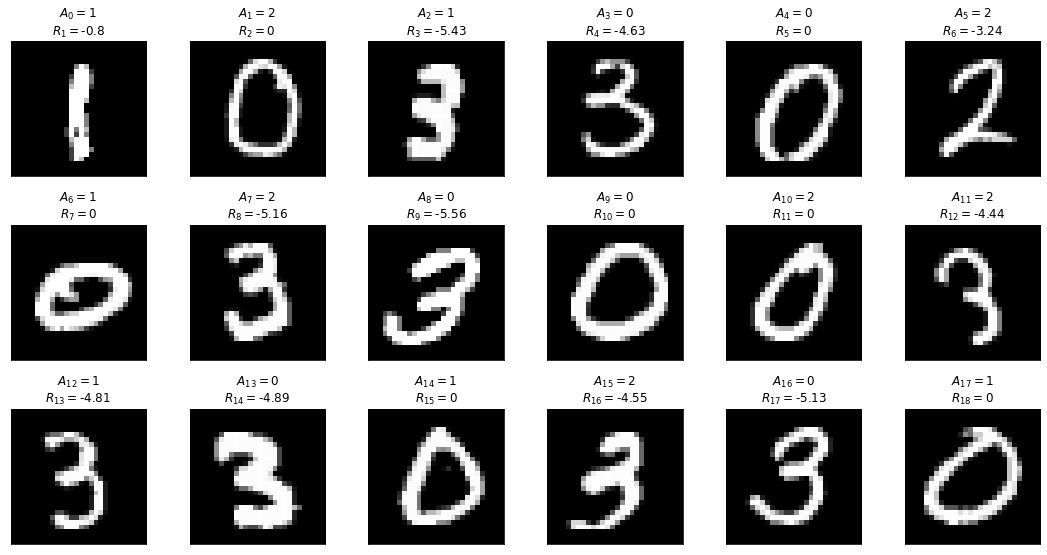

In [18]:
with open('markov_decision_process.pkl', 'rb') as f:
    images, actions, rewards = pickle.load(f)
    
# This cheat switches the problem on its head; we start looking for the worst action
#rewards = np.abs(rewards)

k = 0
fig = plt.figure(figsize=(15,8))
for t in range(18):
    k += 1
    plt.subplot(3,6,k)
    plt.tight_layout()
    plt.imshow(images[t], cmap='gray', interpolation='none')
    plt.title("$A_{" + str(t) + "}=$"+str(actions[t])+"\n$R_{" + str(t+1) + "}=$"+str(round(rewards[t],2)))
    plt.xticks([])
    plt.yticks([])
    
actions_1hot = pd.get_dummies(actions)
ims = images.reshape(-1, 784).astype('float32')
ims /= 255
print("Image shape: {}.".format(ims.shape))
X = np.concatenate((ims, np.array(actions_1hot)), axis = 1)
print("Image shape with actions: {}.".format(X.shape))
# --- 
X0 = X.copy()
X1 = X.copy()
X2 = X.copy()
X0[:,784:787] = 0
X0[:,784] = 1
X1[:,784:787] = 0
X1[:,785] = 1
X2[:,784:787] = 0
X2[:,786] = 1

In [19]:
set(actions)

{0, 1, 2}

---

- train the NN in mini-batches of size 128, that is, the weights ${\bf w}$ will be updated every 128 time steps
- update the target $R_{t+1}+\gamma\hat{v}(S_{t+1},{\bf w})$ every 1280 time steps only, that is, not the most recent weights should be used to evaluate this taget  - this usually guarantees a better stability of the algorithm

In [20]:
# NN 
# Hyper-parameters
BATCH_SIZE = 128
INPUT_SHAPE = (787,)
KERNEL_SIZE = 4
FILTER_SIZE = 4 
# ---------

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=INPUT_SHAPE))                          
model.add(Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(1, activation='relu'))

model.compile(loss='mse',  metrics=['mse'], optimizer='adam')

# ----

T = len(rewards)
gamma = 0.9
chunk_size = 1280
n_chunks = int(T/chunk_size)
V0 = 0
alpha = 0.1

for k in range(n_chunks):
    time_range = np.arange(chunk_size*k, chunk_size*(k+1))
    print("Current time: {}".format(time_range[0]))
    
    q_hat0 = model.predict(X0[time_range+1])
    q_hat1 = model.predict(X1[time_range+1])
    q_hat2 = model.predict(X2[time_range+1])
    
    # Hmm
    q_hatOpt = np.min(np.concatenate((q_hat0,q_hat1,q_hat2),axis=1),axis=1)
    target = -np.array(rewards)[time_range] + gamma*q_hatOpt
    # 1-Step TD
    V1 = V0 + alpha*(target - V0)
    V0 = V1
    print(V1)
    history = model.fit(X[time_range], target, batch_size = 128, epochs=10)#, verbose = 1)
    
model.predict(X).max()

Current time: 0
[0.1110485  0.05858445 0.58316943 ... 0.55339347 0.5218846  0.57691136]
Epoch 1/10
10/10 [==============================] - 0s 1ms/step - loss: 5.0414 - mse: 5.0414
Epoch 2/10
10/10 [==============================] - 0s 1ms/step - loss: 1.5603 - mse: 1.5603
Epoch 3/10
10/10 [==============================] - 0s 1ms/step - loss: 1.0490 - mse: 1.0490
Epoch 4/10
10/10 [==============================] - 0s 1ms/step - loss: 0.7963 - mse: 0.7963
Epoch 5/10
10/10 [==============================] - 0s 1ms/step - loss: 0.6198 - mse: 0.6198
Epoch 6/10
10/10 [==============================] - 0s 1ms/step - loss: 0.5353 - mse: 0.5353
Epoch 7/10
10/10 [==============================] - 0s 1ms/step - loss: 0.4553 - mse: 0.4553
Epoch 8/10
10/10 [==============================] - 0s 1ms/step - loss: 0.4015 - mse: 0.4015
Epoch 9/10
10/10 [==============================] - 0s 1ms/step - loss: 0.3198 - mse: 0.3198
Epoch 10/10
10/10 [==============================] - 0s 1ms/step - loss: 0.

10/10 [==============================] - 0s 1ms/step - loss: 0.7129 - mse: 0.7129
Epoch 9/10
10/10 [==============================] - 0s 1ms/step - loss: 0.6931 - mse: 0.6931
Epoch 10/10
10/10 [==============================] - 0s 1ms/step - loss: 0.6725 - mse: 0.6725
Current time: 20480
[8.3145932  7.95284649 8.22629929 ... 6.61744108 8.05684339 8.51342077]
Epoch 1/10
10/10 [==============================] - 0s 1ms/step - loss: 1.6674 - mse: 1.6674
Epoch 2/10
10/10 [==============================] - 0s 1ms/step - loss: 1.3381 - mse: 1.3381
Epoch 3/10
10/10 [==============================] - 0s 1ms/step - loss: 1.1019 - mse: 1.1019
Epoch 4/10
10/10 [==============================] - 0s 1ms/step - loss: 0.9854 - mse: 0.9854
Epoch 5/10
10/10 [==============================] - 0s 1ms/step - loss: 0.9608 - mse: 0.9608
Epoch 6/10
10/10 [==============================] - 0s 1ms/step - loss: 0.8272 - mse: 0.8272
Epoch 7/10
10/10 [==============================] - 0s 1ms/step - loss: 0.8780 - 

Epoch 2/10
10/10 [==============================] - 0s 1ms/step - loss: 0.7697 - mse: 0.7697
Epoch 3/10
10/10 [==============================] - 0s 1ms/step - loss: 0.6720 - mse: 0.6720
Epoch 4/10
10/10 [==============================] - 0s 1ms/step - loss: 0.5916 - mse: 0.5916
Epoch 5/10
10/10 [==============================] - 0s 1ms/step - loss: 0.5595 - mse: 0.5595
Epoch 6/10
10/10 [==============================] - 0s 1ms/step - loss: 0.5594 - mse: 0.5594
Epoch 7/10
10/10 [==============================] - 0s 1ms/step - loss: 0.5363 - mse: 0.5363
Epoch 8/10
10/10 [==============================] - 0s 1ms/step - loss: 0.4828 - mse: 0.4828
Epoch 9/10
10/10 [==============================] - 0s 1ms/step - loss: 0.4756 - mse: 0.4756
Epoch 10/10
10/10 [==============================] - 0s 1ms/step - loss: 0.4689 - mse: 0.4689
Current time: 40960
[10.31587017  9.66104645  9.56659349 ...  9.97592871 10.6154865
 11.05516462]
Epoch 1/10
10/10 [==============================] - 0s 1ms/step 

16.974838

In [21]:
# Predict!
q_hat0 = model.predict(X0)
q_hat1 = model.predict(X1)
q_hat2 = model.predict(X2)
AOpt = np.argmin(np.concatenate((q_hat0,q_hat1,q_hat2),axis=1),axis=1)
AOpt.shape
AOpt

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

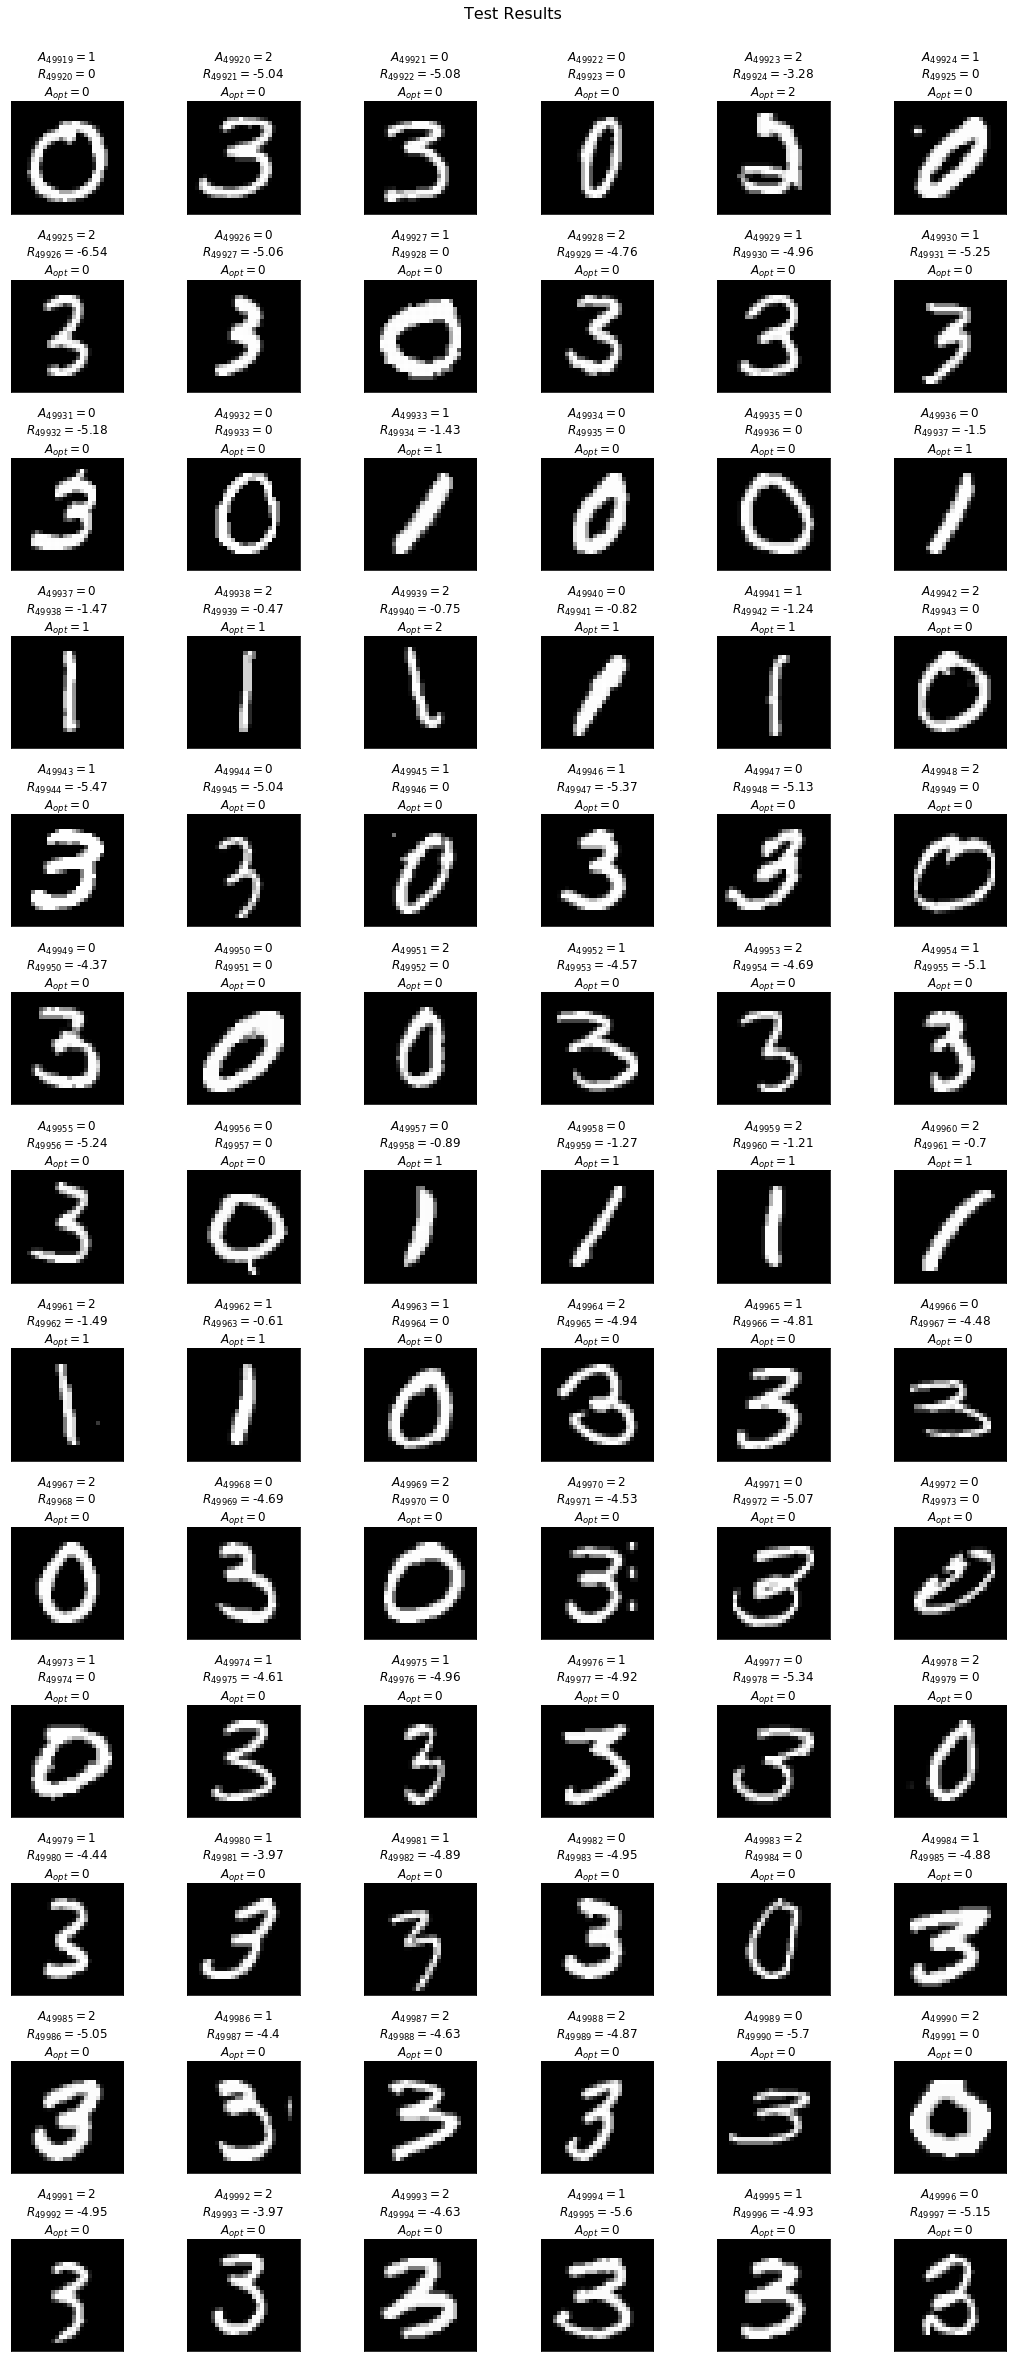

In [22]:
k = 0
fig = plt.figure(figsize=(15,2.5*13))
fig.suptitle('Test Results',y=1.014,size=16)
for t in range(49919,49919+6*13):
    k += 1
    plt.subplot(13,6,k)
    plt.tight_layout()
    plt.imshow(images[t], cmap='gray', interpolation='none')
    plt.title("$A_{"+str(t)+"}=$"+str(actions[t])+"\n$R_{"+str(t+1)+"}=$"+str(round(rewards[t],2))+"\n$A_{opt}=$"+str(AOpt[t]))
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [23]:
# - End
# Thanks for the class - have a great remainder of your summer!
# Andrew Caide